## Read output of experiments

In [24]:
%pip install pandas -q
%pip install matplotlib -q
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd

# Remember to set the output path from your experiments.
base_df = pd.read_csv("../eval_output/gemini/transcript/single_output.csv")
template_df = pd.read_csv("../eval_output/gemini/transcript/multi_output.csv")
recap_df = pd.read_csv("../eval_output/gemini/transcript/recap_output.csv")
rag_df = pd.read_csv("../eval_output/gemini/transcript/rag_multi_output.csv")
cat_df = pd.read_csv("../eval_output/gemini/transcript/cat_multi_ouput.csv")
rag_cat_df = pd.read_csv("../eval_output/gemini/transcript/cat_rag_multi_ouput.csv")
only_cat_df = pd.read_csv("../eval_output/gemini/transcript/only_cat_output.csv")

In [26]:
score_columns = ['FAC', 'INF', 'REL', 'OVR']

In [27]:
def separate_score_columns(df):
    df_split = pd.json_normalize(df['Score_Unknown Role'].apply(eval))  # Convert string dict to actual dict
    df = pd.concat([df.drop(columns=['Score_Unknown Role']), df_split], axis=1)
    return df

Create score columns based on string dictionary "{'FAC': 5, 'INF': 4, 'REL': 5, 'OVR': 5}"

In [28]:
base_df = separate_score_columns(base_df)
template_df = separate_score_columns(template_df)
recap_df = separate_score_columns(recap_df)
rag_df = separate_score_columns(rag_df)
cat_df = separate_score_columns(cat_df)
rag_cat_df = separate_score_columns(rag_cat_df)
only_cat_df = separate_score_columns(only_cat_df)


In [29]:
# We just load the meeting that has shared documents (number_token_shared_docs > 0)
path = "token_data.csv"
df = pd.read_csv(path)
df = df[df["num_tokens_shared_doc"] > 0]
df.head()

,file,num_tokens_transcripts,num_tokens_summary,num_tokens_shared_doc
0,ES2004d.json,11420,176,131699
1,ES2008b.json,10489,153,133296
3,IS1004d.json,8416,203,14540
4,IS1008a.json,5233,161,7285
6,IS1004a.json,2565,179,14540


In [30]:
short_threshold = df['num_tokens_shared_doc'].quantile(0.33)
long_threshold = df['num_tokens_shared_doc'].quantile(0.66)
print(f"Short: < {short_threshold}, Medium: ≥ {short_threshold} < {long_threshold}, Long: ≥ {long_threshold}")

Short: < 7285.0, Medium: ≥ 7285.0 < 117904.0, Long: ≥ 117904.0


In [31]:
def get_average_score_by_df(input_df):
    items_to_filter = list(df[df["num_tokens_shared_doc"]<short_threshold]["file"])
    # Filter the DataFrame

    # Filter the DataFrame
    short_df = input_df[input_df['Item'].isin(items_to_filter)]
    short_df

    averages = short_df[score_columns].mean()

    # Display the averages
    avg_df = averages.to_frame(name='Short_Average_Score')

    avg_df.head()

    # Get items where num_tokens_shared_doc is in the medium range
    items_to_filter = list(df[(df["num_tokens_shared_doc"] >= short_threshold) & 
                            (df["num_tokens_shared_doc"] < long_threshold)]["file"])

    medium_df = input_df[input_df['Item'].isin(items_to_filter)]
    medium_df

    averages = medium_df[score_columns].mean()

    # Display the averages
    avg_df['Medium_Average_Score'] = averages

    avg_df.head()

    # Get items where num_tokens_shared_doc is in the medium range
    items_to_filter = list(df[df["num_tokens_shared_doc"] >= long_threshold]["file"])
    # Filter the DataFrame
    long_df = input_df[input_df['Item'].isin(items_to_filter)]
    long_df

    averages = long_df[score_columns].mean()

    # Display the averages
    avg_df['Long_Average_Score'] = averages
    avg_df.head()
    return avg_df



Calculate the average score of all experiments

In [32]:
base_avg_df = get_average_score_by_df(base_df)
template_avg_df = get_average_score_by_df(template_df)
recap_avg_df = get_average_score_by_df(recap_df)
rag_avg_df = get_average_score_by_df(rag_df)
cat_avg_df = get_average_score_by_df(cat_df)
rag_cat_avg_df = get_average_score_by_df(rag_cat_df)
only_cat_avg_df = get_average_score_by_df(only_cat_df)

Visualize on the line chart

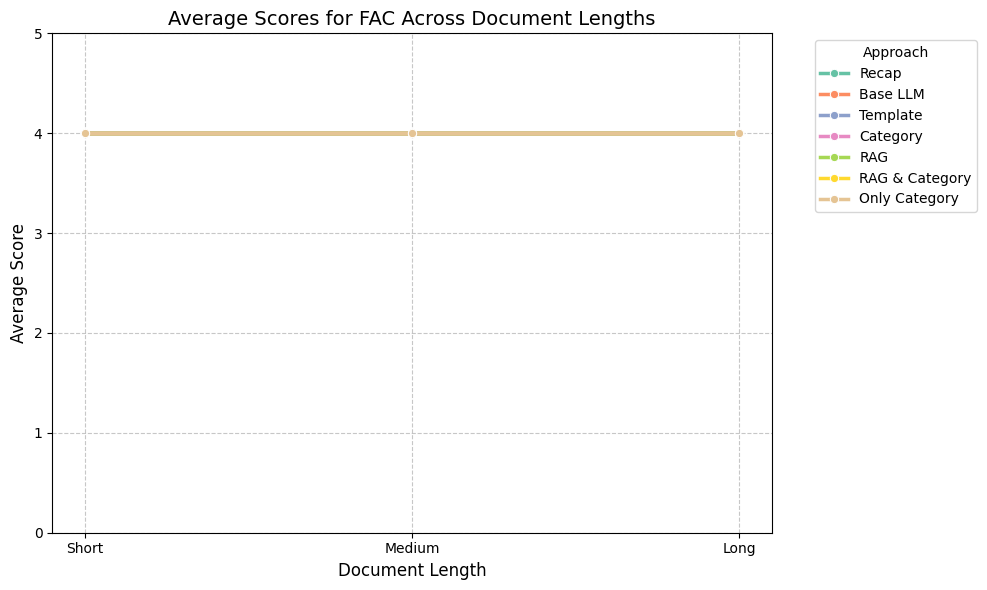

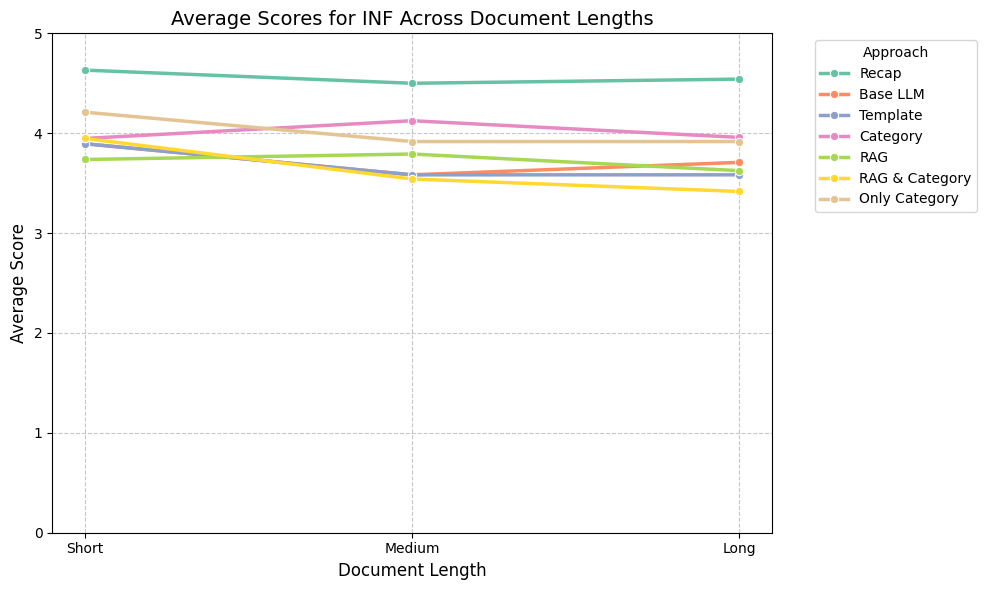

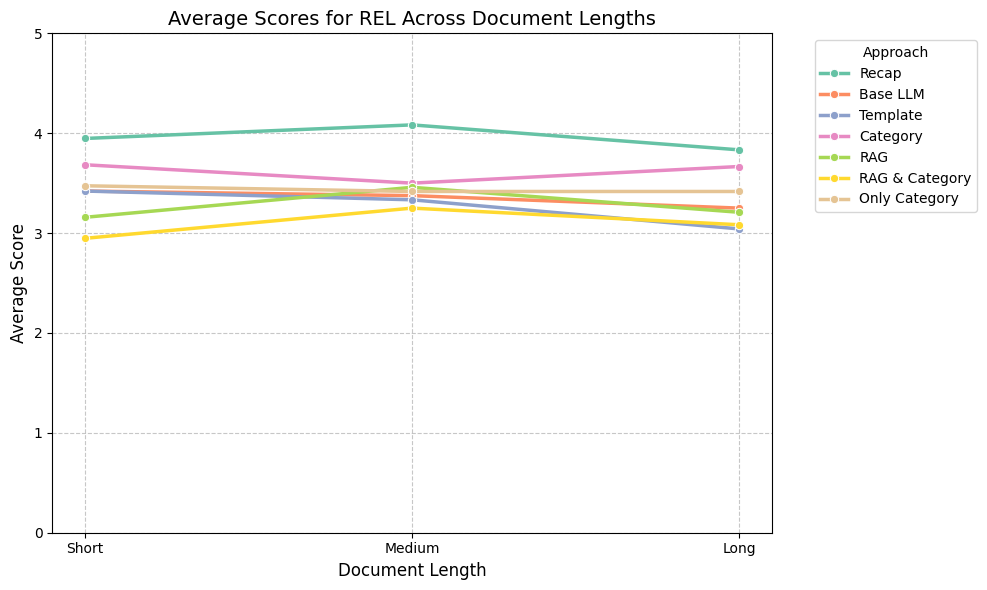

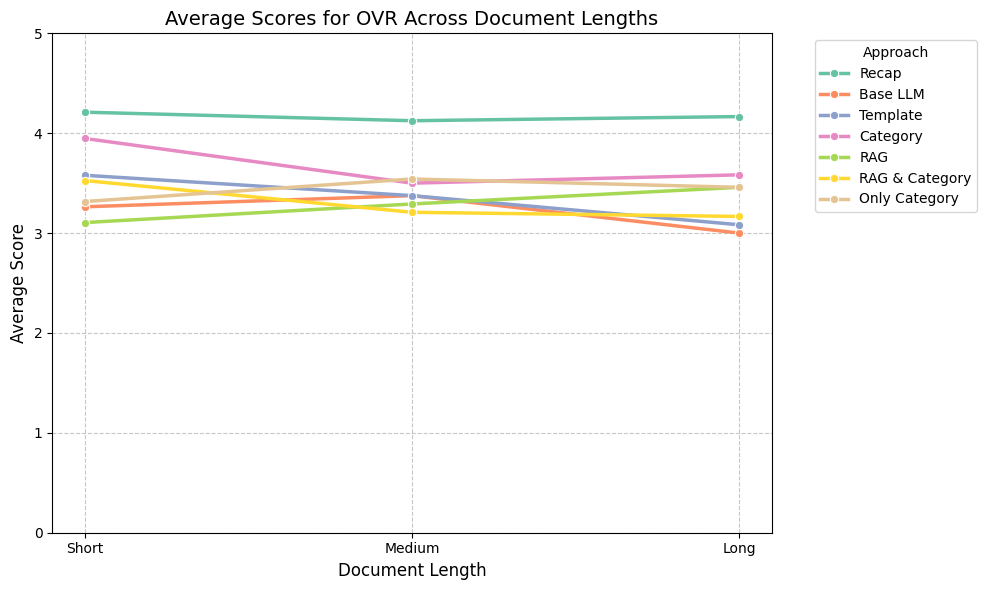

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_df is created earlier with this approach
approach_dfs = {
    'recap_avg_df': 'Recap',
    'base_avg_df': 'Base LLM',
    'template_avg_df': 'Template',
    'cat_avg_df': 'Category',
    'rag_avg_df': 'RAG',
    'rag_cat_avg_df': 'RAG & Category',
    'only_cat_avg_df': 'Only Category'
}

# Debug: Check which DataFrames exist
available_dfs = {}
for df_name in approach_dfs.keys():
    if df_name in globals():
        available_dfs[df_name] = globals()[df_name]
        available_dfs[df_name]['Approach'] = approach_dfs[df_name]
    else:
        print(f"Warning: '{df_name}' not found in global namespace. Skipping...")

# Combine only available DataFrames
combined_df = pd.concat([df for df in available_dfs.values()], ignore_index=False)

# Reset index to make Criterion a column
combined_df = combined_df.reset_index().rename(columns={'index': 'Criterion'})

# Melt the DataFrame into long format
df_melted = combined_df.melt(id_vars=['Approach', 'Criterion'], 
                             value_vars=['Short_Average_Score', 'Medium_Average_Score', 'Long_Average_Score'],
                             var_name='Length', value_name='Score')

# Clean up Length names
df_melted['Length'] = df_melted['Length'].replace({
    'Short_Average_Score': 'Short',
    'Medium_Average_Score': 'Medium',
    'Long_Average_Score': 'Long'
})

# Ensure Length is categorical with correct order
df_melted['Length'] = pd.Categorical(df_melted['Length'], categories=['Short', 'Medium', 'Long'], ordered=True)

# List of criteria to plot separately
criteria = ['FAC', 'INF', 'REL', 'OVR']

# Create separate line plots for each criterion
for criterion in criteria:
    plt.figure(figsize=(10, 6))  # Set figure size for each plot
    sns.lineplot(data=df_melted[df_melted['Criterion'] == criterion], 
                 x='Length', y='Score', hue='Approach', 
                 marker='o', palette='Set2', linewidth=2.5)
    
    # Customize each plot
    plt.ylim(0, 5)  # Adjust y-axis to focus on score range (4-5.5)
    plt.title(f'Average Scores for {criterion} Across Document Lengths', fontsize=14)
    plt.xlabel('Document Length', fontsize=12)
    plt.ylabel('Average Score', fontsize=12)
    plt.legend(title='Approach', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()